In [15]:
import sys

sys.path.append("..")

In [16]:
import random

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, r2_score
import matplotlib.pyplot as plt

from src.util import *
from src.model import *

tqdm.pandas()

In [17]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

In [18]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
)

train_dataset, test_dataset, user_embedding_weight = create_dataset(
    interaction_df=interaction_df,
    train_split_date=train_split_date,
    test_split_date=test_split_date,
)

100%|██████████| 25093/25093 [00:00<00:00, 110356.17it/s]


In [19]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

target_loss_weight = 100
clv_loss_weight = 1
alpha = target_loss_weight / (target_loss_weight + clv_loss_weight)

args = Args(
    d_model=32,
    batch_size=64,
    nhead=4,
    epochs=30,
    lr=1e-3,
    sample_size=5,
    alpha=alpha,
    device=device,
    model_path="model.model",
)

try:
    model = torch.load(args.model_path)
    print(f"loaded model from: {args.model_path}")
except FileNotFoundError:
    model = Model(
        user_embedding_weight=user_embedding_weight,
        item_size=len(item_le.classes_),
        d_model=args.d_model,
        nhead=args.nhead,
    )
model.to(args.device)
model.train()

print(f"args: {args}")
train_results, test_results = train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    args=args,
    item_size=len(item_le.classes_),
)

args: Args(d_model=32, batch_size=64, nhead=4, epochs=30, lr=0.001, sample_size=5, alpha=0.0, context_item_size=9, device='mps', model_path='model_alpha_0.model')
[epoch: 1/30]


 34%|███▎      | 132/393 [00:08<00:17, 15.10it/s]


KeyboardInterrupt: 

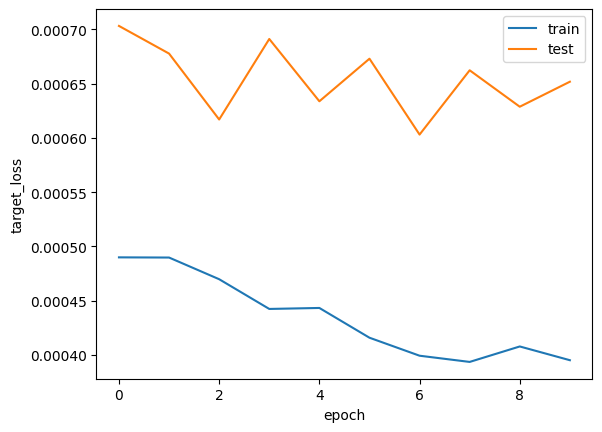

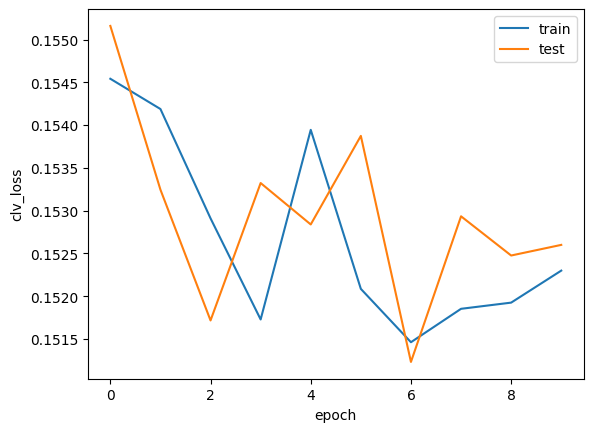

In [ ]:
loss_names = ["target", "clv"]
for loss_name in loss_names:
    train_losses = list(map(lambda result: result[loss_name]["loss"], train_results))
    test_losses = list(map(lambda result: result[loss_name]["loss"], test_results))
    plt.plot(train_losses, label="train")
    plt.plot(test_losses, label="test")
    plt.xlabel("epoch")
    plt.ylabel(f"{loss_name}_loss")
    plt.legend()
    plt.show()

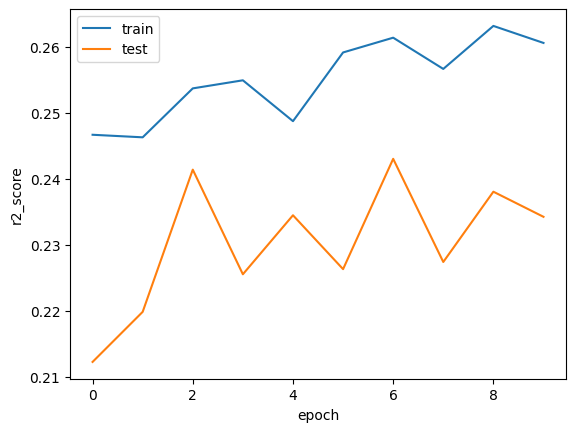

In [ ]:
train_r2_scores = list(map(lambda result: r2_score(result["clv"]["y_true"], result["clv"]["y_pred"]), train_results))
test_r2_scores = list(map(lambda result: r2_score(result["clv"]["y_true"], result["clv"]["y_pred"]), test_results))

plt.plot(train_r2_scores, label="train")
plt.plot(test_r2_scores, label="test")
plt.xlabel("epoch")
plt.ylabel(f"r2_score")
plt.legend()
plt.show()

Text(0, 0.5, 'y_pred')

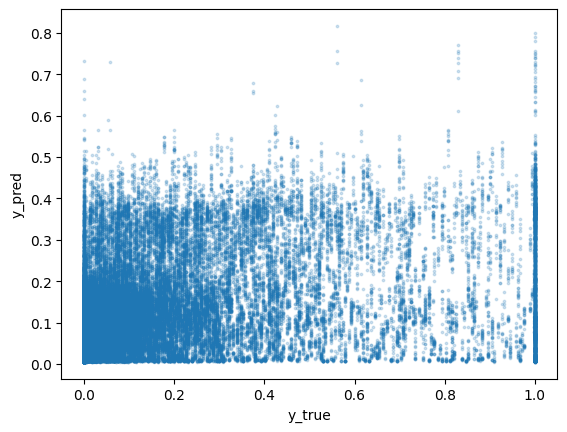

In [ ]:
plt.scatter(train_results[-1]["clv"]["y_true"], train_results[-1]["clv"]["y_pred"], alpha=0.2, s=3)
plt.xlabel("y_true")
plt.ylabel("y_pred")

ROC: 0.9694702570963645


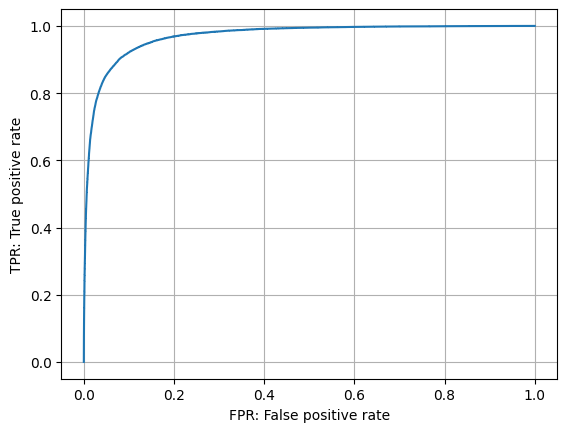

ROC: 0.9351301395651477


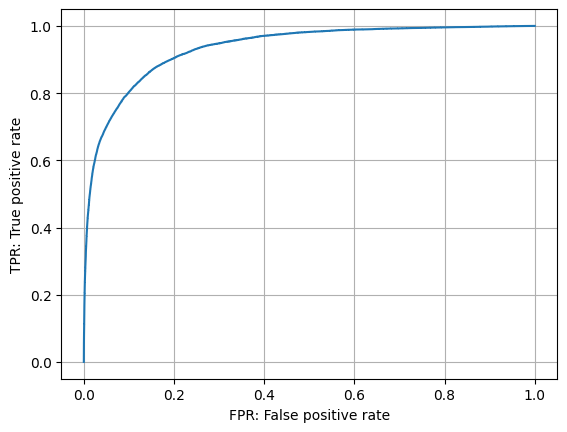

In [ ]:
def plot_roc_auc(results: list[dict]):
    fpr, tpr, _ = roc_curve(
        results[-1]["target"]["y_true"], results[-1]["target"]["y_pred"]
    )
    print("ROC:", roc_auc_score(results[-1]["target"]["y_true"], results[-1]["target"]["y_pred"]))

    plt.plot(fpr, tpr)
    plt.xlabel("FPR: False positive rate")
    plt.ylabel("TPR: True positive rate")
    plt.grid()
    plt.show()

plot_roc_auc(train_results)
plot_roc_auc(test_results)